In [1]:
%run Imports.ipynb
from quantpy.tomography.interval import ConfidenceInterval, _pop_hidden_keys, Mode

import numpy as np
import scipy.linalg as la
import scipy.stats as sts
import math

from enum import Enum, auto
from abc import ABC, abstractmethod
from scipy.interpolate import interp1d
from collections import Counter, defaultdict
from functools import partial

from quantpy.geometry import hs_dst, trace_dst, if_dst
from quantpy.qobj import Qobj
from quantpy.routines import (
    _left_inv, _vec2mat, _mat2vec,
    _matrix_to_real_tril_vec, _real_tril_vec_to_matrix,
)

titlesize = 40
labelsize = 64
legendsize = 44
xticksize = 50
yticksize = xticksize
linewidth = 3
fontsize = 60
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize
matplotlib.rcParams['font.size'] = fontsize
matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

In [2]:
results = {'Ry13_Id': {'__0__': 3520, '__1__': 4672},
           'Ry13_Rx': {'__0__': 4033, '__1__': 4159},
           'Ry13_Ry': {'__0__': 1589, '__1__': 6603},
           'RyRz23_Id': {'__0__': 3593, '__1__': 4599},
           'RyRz23_Rx': {'__0__': 6834, '__1__': 1358},
           'RyRz23_Ry': {'__0__': 5488, '__1__': 2704},
           'RyRz43_Id': {'__0__': 3515, '__1__': 4677},
           'RyRz43_Rx': {'__0__': 2403, '__1__': 5789},
           'RyRz43_Ry': {'__0__': 6167, '__1__': 2025},
           'nothing_Id': {'__0__': 7473, '__1__': 719},
           'nothing_Rx': {'__0__': 4373, '__1__': 3819},
           'nothing_Ry': {'__0__': 4288, '__1__': 3904}}

In [3]:
POVM_base = np.array([
    [0.972, 0],
    [0, 0.093],
])

POVM_3 = [POVM_base, np.eye(2) - POVM_base]
POVM_2 = [qp.operator.RX(np.pi / 2).H.as_channel().transform(elem) for elem in POVM_3]
POVM_1 = [qp.operator.RY(np.pi / 2).H.as_channel().transform(elem) for elem in POVM_3]

POVM_3_matrix = np.array([qp.Qobj(elem).bloch for elem in POVM_3])
POVM_2_matrix = np.array([qp.Qobj(elem).bloch for elem in POVM_2])
POVM_1_matrix = np.array([qp.Qobj(elem).bloch for elem in POVM_1])

povm_matrix = np.stack([POVM_1_matrix, POVM_2_matrix, POVM_3_matrix], axis=0)

In [4]:
ry = qp.operator.RY(np.arccos(-1 / 3)).as_channel()
rz23 = qp.operator.RZ(np.pi * 2 / 3).as_channel()
rz43 = qp.operator.RZ(np.pi * 4 / 3).as_channel()

state_1 = qp.Qobj([1, 0], True)
state_2 = ry.transform(state_1)
state_3 = rz23.transform(state_2)
state_4 = rz43.transform(state_2)

input_basis = [state_1, state_2, state_3, state_4]

In [5]:
target_channel = qp.operator.Id.as_channel()
tmg = qp.ProcessTomograph(target_channel, input_states=input_basis)
tmg.experiment(8192, povm_matrix)

results = np.asarray([
    [
        [4288, 3904],
        [4373, 3819],
        [7473, 719],
    ],
    [
        [1589, 6603],
        [4033, 4159],
        [3520, 4672],
    ],
    [
        [5488, 2704],
        [6834, 1358],
        [3593, 4599],
    ],
    [
        [6167, 2025],
        [2403, 5789],
        [3515, 4677],
    ],
])
tmg.results = results

# tmg.tomographs[0].results = np.array([4288, 3904, 4373, 3819, 7473, 719])
# tmg.tomographs[1].results = np.array([1589, 6603, 4033, 4159, 3520, 4672])
# tmg.tomographs[2].results = np.array([5488, 2704, 6834, 1358, 3593, 4599])
# tmg.tomographs[3].results = np.array([6167, 2025, 2403, 5789, 3515, 4677])

channel_hat = tmg.point_estimate()
fidelity = np.dot(target_channel.choi.bloch, channel_hat.choi.bloch)
interval = qp.tomography.interval.MomentFidelityProcessInterval(tmg, target_process=target_channel)
# conf_levels = np.linspace(0.981, 1-1e-5, 100)
conf_levels = np.linspace(1e-3, 1-1e-3, 10000)
# A, b = interval.setup()
(dist_min, dist_max), conf_levels = interval(conf_levels)
epsilons = 1 - conf_levels

In [6]:
dist_min

array([0.84870799, 0.84865928, 0.84861057, ..., 0.82813755, 0.82806396,
       0.82795528])

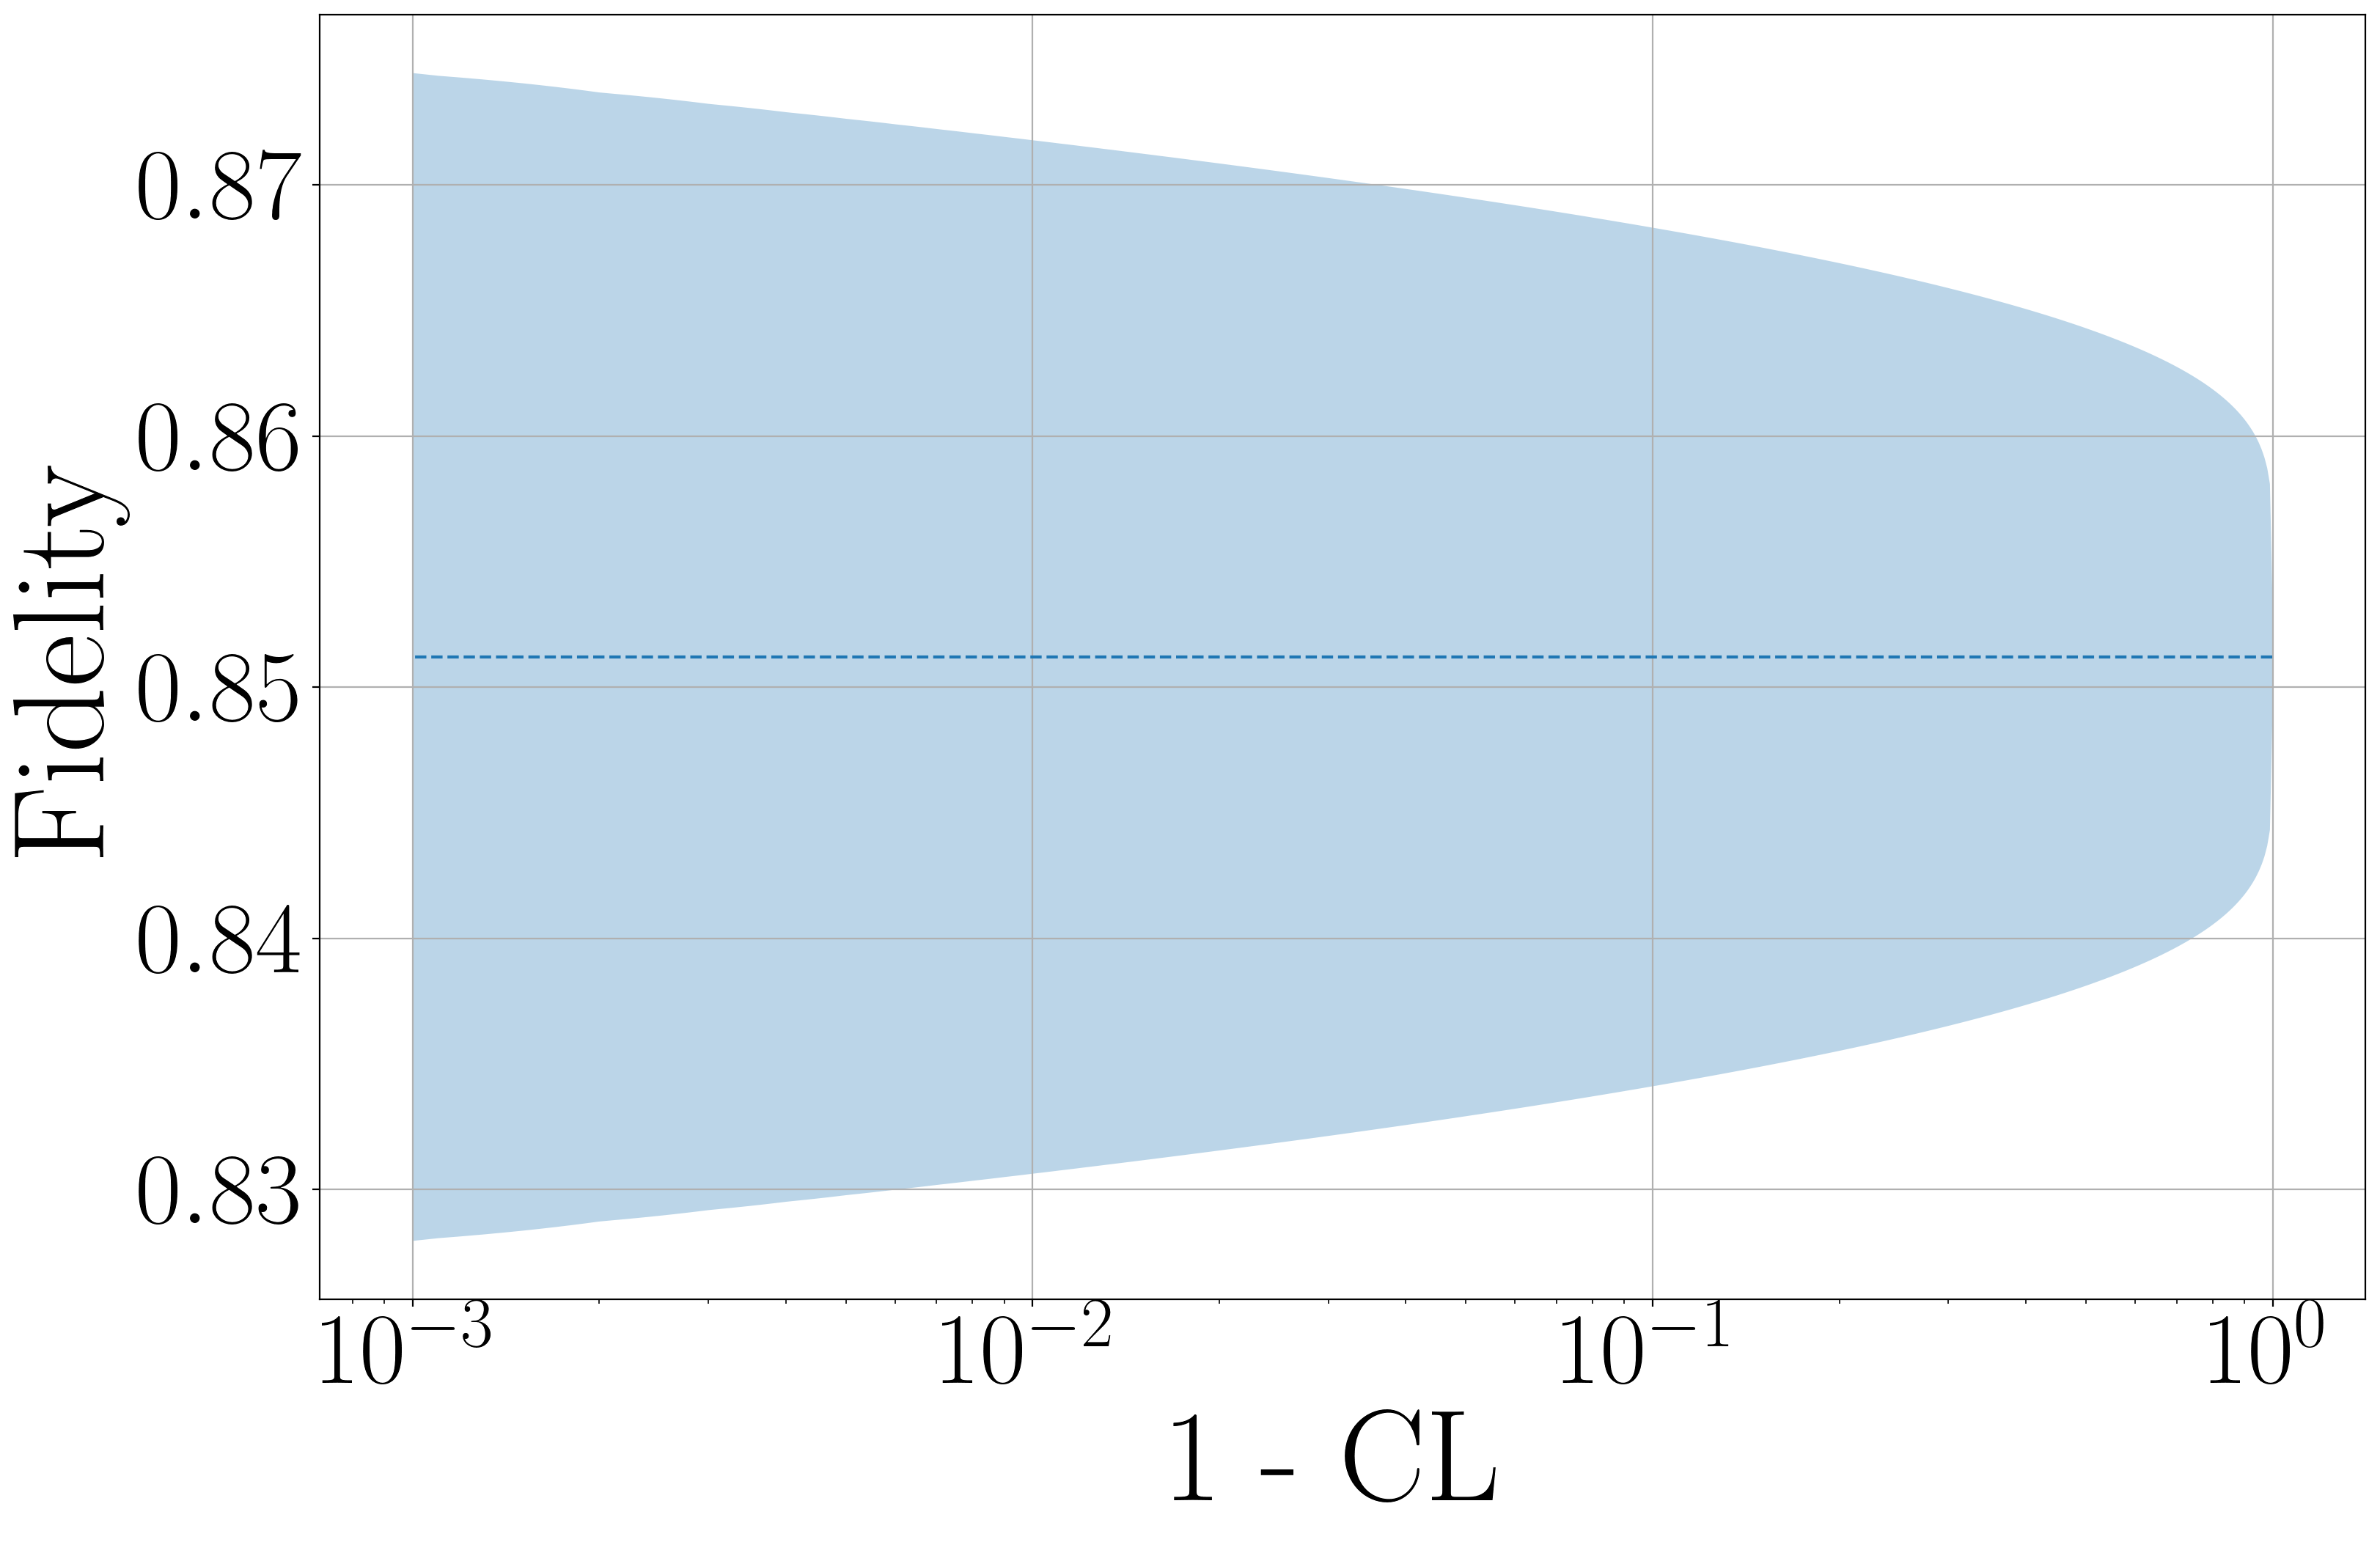

In [8]:
plt.figure(figsize=(18, 12), dpi=200)
plt.xlabel('1 - CL')
plt.ylabel('Fidelity')
plt.grid()
plt.fill_between(epsilons, dist_min, dist_max, alpha=0.3)
plt.xscale('log')
plt.plot([epsilons[0], epsilons[-1]], [fidelity] * 2, '--')
# plt.figtext(0.02, 0.9, "a)")
plt.subplots_adjust(bottom=0.15)
plt.savefig('../data/fig_2a.pdf')

In [41]:
tomographs = [PolytopeTomograph(state) for state in input_basis]
for tmg in tomographs:
    tmg.experiment(8192, POVM_matrix)

tomographs[0].results = np.array([4288, 3904, 4373, 3819, 7473, 719])
tomographs[1].results = np.array([1589, 6603, 4033, 4159, 3520, 4672])
tomographs[2].results = np.array([5488, 2704, 6834, 1358, 3593, 4599])
tomographs[3].results = np.array([6167, 2025, 2403, 5789, 3515, 4677])

for n in range(4):
    tomographs[n].raw_results = tomographs[n].results.reshape((3, 2))

In [33]:
# japan_data = go.Data([go.Surface(x=x, y=y, z=z, opacity=0.25)])
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=vertices[:, 0], y=vertices[:, 1], z=vertices[:, 2], name='Polytope'))
fig.add_trace(go.Scatter3d(x=[target_state.bloch[1]], y=[target_state.bloch[2]], z=[target_state.bloch[3]],
                           name='Target state'))
# fig.add_trace(go.Scatter3d(x=[state.bloch[1]], y=[state.bloch[2]], z=[state.bloch[3]],
#                            name='Prepared state'))
fig.add_trace(go.Scatter3d(x=[state_hat.bloch[1]], y=[state_hat.bloch[2]], z=[state_hat.bloch[3]],
                           name='Estimated state'))
fig.update_layout(title=f"epsilons=[{epsilons[0, 0]:.4f}, {epsilons[1, 0]:.4f}, {epsilons[2, 0]:.4f}]")
fig.show()